### 样式迁移
> * 将样式图片中的样式迁移到内容图片上，得到合成图片
![](../images/Style-Transfer.png)
> * 输入内容图像和风格图像，输出风格迁移后的合成图像

#### 方法
> * 首先，初始化合成图像，例如将其初始化为内容图像。该<font color='red'>合成图像是样式迁移过程中唯一需要更新的变量</font>，即样式迁移所需迭代的模型参数。
> * 然后，选择一个预训练的卷积神经网络来抽取图像的特征，其中的<font color='red'>模型参数不需要更新</font>。
> * 深度卷积神经凭借多个层逐级抽取图像的特征，选择其中某些层的输出作为内容特征或样式特征。
>> * 下图选取的预训练神经网络含有3个卷积层，其中第二层作为输出内容特征，第一层和第三层作为样式特征。
![](../images/Style-Transfer_Process.png)
> * 接下来，通过前向传播（实线箭头方向）计算样式迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。样式迁移常用损失函数由3部分组成：
>> * <font color='red'>内容损失</font>使合成图像与内容图像在特征内容上接近
>> * <font color='red'>样式损失</font>使合成图像与样式图像在风格特征上接近
>> * <font color='red'>全变分损失</font>则有助于减少合成图像中的噪音
> * 最后，当模型训练结束后，输出样式迁移的模型参数，即得到最终的合成图像

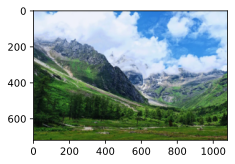

In [5]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import limutorch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../images/Landscape.png')
d2l.plt.imshow(content_img)

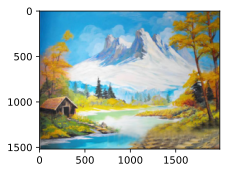

In [6]:
style_img = d2l.Image.open('../images/Painting.png')
d2l.plt.imshow(style_img)

In [18]:
"""预处理和后处理"""
## 这里是ImageNet上的均值和方差
rgb_mean = torch.tensor([0.485, -.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

"""预处理函数preprocess对输入图像在RGB三个通道分别做标准化， 并将结果变换为卷积神经网络接受的输入格式"""
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

"""后处理函数postprocess则将输出图像中的像素值还原回标准之前的值。"""
def postprocess(img):
    img = img[0].to(rgb_std.device)

    """
        由于图像打印函数要求每个像素的浮点数值在0~1之间，对于小于0和大于1之间的值分别取0和1
        torch.clamp(x, 0, 1)起到的就是这样的效果，对于输入张量的大小被限制为0~1之间
    """
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [8]:
"""抽取凸显特征"""
pretrained_net = torchvision.models.vgg19(pretrained=True)

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential(
    *[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)]
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 103MB/s]


In [9]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

定义两个函数：get_contents函数对内容图像抽取内容特征；get_styles函数对样式图像抽取样式特征。
因为在训练时无须改变预训练的VGG的模型参数，所以可以在训练开始之前就提取出内容特征和样式特征。
由于合成图像是样式迁移所需迭代的模型参数，只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和样式特征

In [10]:
"""该函数对内容图像抽取内容特征"""
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    content_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, content_Y

"""该函数对样式图像抽取样式特征"""
def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y

In [11]:
"""内容损失"""
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

#### 样式损失
样式损失与内容损失类似，也通过平方误差函数衡量合成图像与样式图像在样式上的差异。为了表达样式层输出的风格，先通过extract_features函数计算样式层的输出。假设输出的样本数为1，通道数为$c$，宽和高分别为$h$和$w$，可以将此输出转换为矩阵$X$，其有$c$行和$hw$列。这个矩阵可以看做由$c$个长度为$hw$的向量$x_1,...,x_c$组合而成。其中向量$x_i$代表了通道$i$上的样式特征。
在这些向量的格拉姆矩阵$XX^T$中，$i$行$j$列的元素$x_{ij}$即向量$x_i$和$x_j$的内积。它表达了通道$i$和通道$j$上的样式特征的相关性。用这样的格拉姆矩阵来表达样式层输出的样式。需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。此外格拉姆矩阵的高和宽皆为通道$c$。为了让样式损失不会收到这些值的影响，下面定义的gram函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$

In [24]:
"""样式损失"""
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### 全变分损失
有时候学到的合成图像里面有大量高频噪音，即有特别亮或者特别暗的颗粒像素。一种常见的去噪方法是<font color='red'>全变分去噪</font>假设$x_{ij}$处的像素值，降低全变分损失能够尽可能使邻近的像素值相似：$\sum_{i, j}|x_{i, j}-x_{i+1, j}| + |x_{i, j} - x_{i, j+1}|$。

In [13]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [22]:
"""损失函数"""
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, content_Y_hat, style_Y_hat, content_Y, style_y_gram):
    content_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(content_Y_hat, content_Y)]
    style_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(style_Y_hat, style_y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(style_l + content_l + [tv_l])
    return content_l, style_l, tv_l, l

In [15]:
"""初始化生成图像"""
class SynthesizedImage(nn.Module):
    def __init__(self, image_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*image_shape))

    def forward(self):
        return self.weight

def get_init(X, device, lr, style_Y):
    gen_image = SynthesizedImage(X.shape).to(device)
    gen_image.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_image.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in style_Y]
    return gen_image(), styles_Y_gram, trainer

In [26]:
"""训练模型"""
def train(X, content_Y, style_Y, device, lr, num_epochs, lr_decay_epoch):
    X, style_Y_gram, trainer = get_init(X, device, lr, style_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss',
        xlim=[10, num_epochs], legend=['content', 'style', 'TV'],
        ncols=2, figsize=(7, 2.5)
    )
    for epoch in range(num_epochs):
        trainer.zero_grad()
        content_Y_hat, style_Y_hat = extract_features(X, content_layers, style_layers)
        content_l, style_l, tv_l, l = compute_loss(X, content_Y_hat, style_Y_hat, content_Y, style_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(content_l)), float(sum(style_l)), float(tv_l)])
    return X

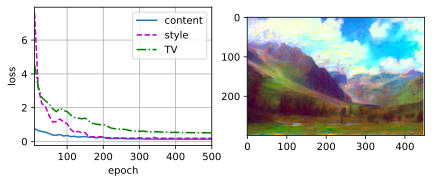

In [27]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
output = train(content_X, content_Y, style_Y, device, 0.3, 500, 50)